# Goal: to predict the sales price for each house. For each Id in the test set, predict the value of the SalePrice

# 1.1 import necessary libraries

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
from scipy.stats import norm

# ML models
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.model_selection import train_test_split, cross_val_score


# preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

# metrics to evaluate regression model
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

## 1.2 Load datasets

In [6]:
train_df=pd.read_csv('train.csv') # contains features and target variable (SalePrice)
test_df =pd.read_csv('test.csv') # only features; 
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
test_df.head() # test_df had same features as train_df except SalePrice (target var)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


# 2. Data Wangling/Processing
## 2.1 Merging training and testing dataframes

In [8]:
## separate target column with unique Id from train_df
target=train_df[['Id','SalePrice']]
target.describe()

,Id,SalePrice
count,1460.000000,1460.000000
mean,730.500000,180921.195890
std,421.610009,79442.502883
min,1.000000,34900.000000
25%,365.750000,129975.000000
50%,730.500000,163000.000000
75%,1095.250000,214000.000000
max,1460.000000,755000.000000


In [9]:
target.isnull().sum() # Glad to see target feature had no missing values

Id           0
SalePrice    0
dtype: int64

In [10]:
train_data=train_df.drop(columns='SalePrice', axis=1) # dropping target column from train_df
train_data.shape

(1460, 80)

### It's great to see no nan's in SalePrice column, minimum value is ~35k; so i can happily slice SalePrice column from train_df; do wrangling and EDA of train and test df's.

In [11]:
test_df.shape

(1459, 80)

### Important to note here the 'Id' column values in train_df and test_df are consecutive, so i can do pre-processing of both training and testing dataframes together by concatenating both datasets row-wise, and slice them before building ML models.

In [12]:
df=pd.concat([train_data,test_df],axis=0)
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [13]:
df['TotalBsmtSF'].replace(0, 1, inplace=True) # Basement range 0-6110 sft; 0 means there is no basement in the house. Rather than removing the rows with 0 basement and/or imputing the 0's with column menas; I am replacing 0 with 1 (just adding 1 sft doesn't inflates the column values)

In [14]:
df['TotalBsmtSF'].describe()

count    2918.000000
mean     1051.804318
std       440.702475
min         1.000000
25%       793.000000
50%       989.500000
75%      1302.000000
max      6110.000000
Name: TotalBsmtSF, dtype: float64

In [15]:
df.shape

(2919, 80)

## 2.2 Missing values

<AxesSubplot:>

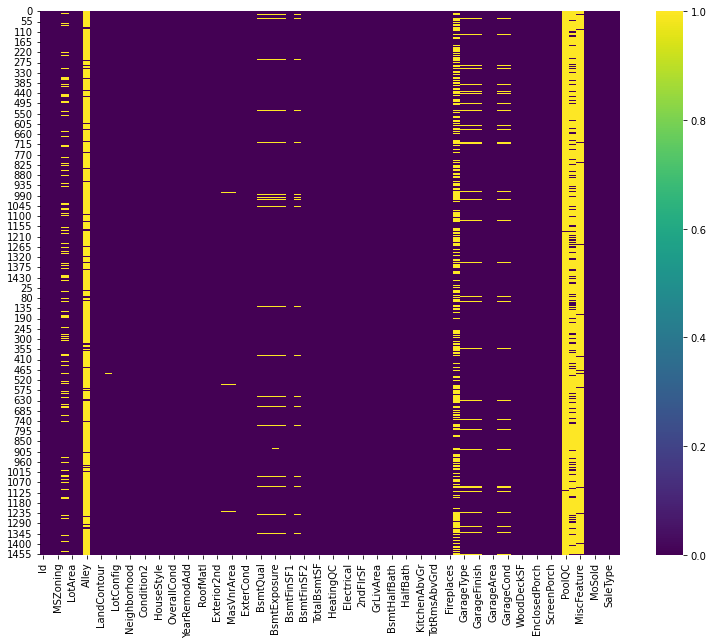

In [16]:
fig, ax = plt.subplots(figsize=(13,10))   
sns.heatmap(df.isnull(), cmap='viridis', ax=ax) # heatmap of missing values

In [17]:
miss_sum=df.isnull().sum()
perc_miss=(df.isnull().sum()/df.isnull().count())*100
missing=pd.concat([miss_sum,perc_miss], axis=1, keys=['Sum_of_missing', 'Percent_missing'])
data=missing.reset_index().sort_values(['Percent_missing'], ascending=False).head(35)
data

,index,Sum_of_missing,Percent_missing
72,PoolQC,2909,99.657417
74,MiscFeature,2814,96.402878
6,Alley,2721,93.216855
73,Fence,2348,80.438506
57,FireplaceQu,1420,48.646797
3,LotFrontage,486,16.649538
59,GarageYrBlt,159,5.447071
60,GarageFinish,159,5.447071
63,GarageQual,159,5.447071
64,GarageCond,159,5.447071


#### Consider removing features with >23 missing values. Also, these are not important features determining house prices. All the garage features except GarageCars had ~5% similar missing data, since GarageCars had less missing data and useful info, I am keeping this column and remove rest of the Garage features. Similarly, keep BsmtSF and remove (BsmtFinType2, BsmtExposure, BsmtQual, BsmtCond, BsmtFinType1 features). MasVnrArea and MasVnrType are not important features, so dropping them doesn't hurt. Finally, some feature had just 1 missing value, so I am dropping those rows instead of entire column.

## 2.2.1 Dropping 18 features with >23 missing values from df and train_df.

In [18]:
print(list(data['index'][:18])) # slice features with high missing data
cols_drop=list(data['index'][:18])
data_set=df.drop(df[cols_drop], axis=1)
data_set.head()

['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'GarageType', 'BsmtExposure', 'BsmtCond', 'BsmtQual', 'BsmtFinType2', 'BsmtFinType1', 'MasVnrType', 'MasVnrArea']


,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,61,0,0,0,0,0,2,2008,WD,Normal
1,2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,0,5,2007,WD,Normal
2,3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,42,0,0,0,0,0,9,2008,WD,Normal
3,4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,35,272,0,0,0,0,2,2006,WD,Abnorml
4,5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,84,0,0,0,0,0,12,2008,WD,Normal


In [19]:
# drop rows with missing values (since some features had only 1-4 missing values, so dropping rows instead of entire column)
data_set=data_set.dropna()
# Making sure no missing data exist
data_set.isnull().sum().sort_values(ascending=False).head()

Id            0
Functional    0
Electrical    0
1stFlrSF      0
2ndFlrSF      0
dtype: int64

In [20]:
data_set.shape

(2906, 62)

In [27]:
data_set.to_csv('wrangled_train_test_data_set.csv')

## Drop same 18 columns from train_df

In [28]:
print(list(data['index'][:18])) # slice features with high missing data
cols_drop=list(data['index'][:18])
train_data_set=train_df.drop(train_df[cols_drop], axis=1)
train_data_set=train_data_set.dropna()
train_data_set.head()

['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'GarageType', 'BsmtExposure', 'BsmtCond', 'BsmtQual', 'BsmtFinType2', 'BsmtFinType1', 'MasVnrType', 'MasVnrArea']


,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000


In [29]:
# Making sure no missing data exist
train_data_set.isnull().sum().sort_values(ascending=False).head()

Id              0
Fireplaces      0
1stFlrSF        0
2ndFlrSF        0
LowQualFinSF    0
dtype: int64

In [30]:
train_data_set.shape

(1459, 63)

In [31]:
train_data_set.to_csv('wrangled_train_data_set.csv')

# Datawrangling Summary:
    -Train.csv contains 81 features including Target variable: SalePrice
    -Test.csv contains 80 features as train.csv but doesn't contain Target variable
    
Since Train.csv and Test.csv contains same features and Id column is consecutive, it's good to concatenate the two dataframes by separating target variable from Train.csv into Target dataframe. 
    -Target dataframe contains Id, SalePrice columns from Train.csv. Having Id column helps later if data frame merging is required. Glad to see target feature had no missing values, no need to drop any rows or imptation of missing data is not needed.
    - concatenated Train.csv features except SalePrice column with same features of Test.csv
    - from combined dataframe, Basement features ranges from 0 to 6110 sft; 0 means there is no basement in the house. Rather than removing the rows with 0 basement and/or imputing the 0's with column menas; I replaced 0 with 1 (just adding 1 sft doesn't inflates the column values)
    - There are 18 features contain >23 missing values, also these are not important features determining house prices. So, dropped these 18 features from combined df and train df.